In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, sosfilt, lfilter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
root = '../../../Data/dataset/'
files =  os.listdir(root)

In [3]:
# signals = np.empty((1,200))
# labels = np.empty(1)
# for csvfile in tqdm(files):
#     df = pd.read_csv(os.path.join(root, csvfile))
# #     print(df.head())
#     label = np.expand_dims(np.array(df['label']), axis = 1)
#     sigs = np.array(df.drop(['label'], axis = 1))
# #     print(label.shape, sigs.shape)
#     signals = np.vstack((signals, sigs))
#     labels = np.vstack((labels, label))
# #     break

In [4]:
# signals = np.array(signals)
# labels = np.array(labels)
signals = np.load("../../../Data/AFData/signals.npy")
labels = np.load("../../../Data/AFData/labels.npy")
print(labels.shape, signals.shape)

(1586000, 1) (1586000, 200)


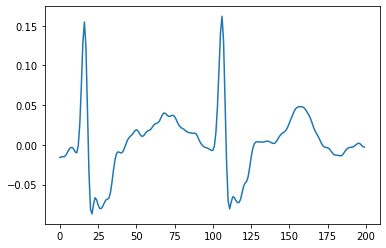

In [15]:
plt.plot(signals[7])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(signals[1:], labels[1:],
                                                    test_size=0.2, stratify=labels[1:],
                                                   random_state=101)

In [6]:
del signals, labels

In [7]:
if not os.path.exists('../../../Data/AFData/signals.npy'):
    np.save('/home/karthiktiwari/Data/AFData/signals.npy', signals)
    np.save('/home/karthiktiwari/Data/AFData/labels.npy', labels)

In [8]:
class AFDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels
#         self.b, self.a = b,a
#         self.sos = sos
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
#         print(self.signals[0].shape)
        signal = torch.Tensor(
            self.process(
                self.signals[idx]
                )
            )
        label = self.labels[idx]
        return {'signal': signal, 'label':label}
    
    def process(self, signal):
#         signal = (signal - np.mean(signal))/ np.std(signal)
#         signal = sosfilt(sos, signal)
#         maxx = np.max(signal)
#         minn = np.min(signal)
#         signal = (signal - minn) / (maxx - minn + 1e-6)
        return signal
            

In [9]:
train_data = AFDataset(X_train, y_train)
test_data = AFDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=2048, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=2048, shuffle = False, num_workers=2)

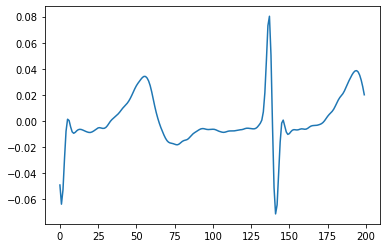

In [10]:
plt.plot(train_data[0]['signal'].numpy())
# print(train_data[0]['signal'].numpy())

In [11]:
# plt.plot(data[0]['signal'].numpy())
# print(labels[1])
# print(np.unique(labels[1:]))

In [12]:
class AFModel(nn.Module):
    def __init__(self):
        super(AFModel, self).__init__()
        self.lstm1 = nn.LSTM(1,32,batch_first=True)
        self.lstm2 = nn.LSTM(32,64,batch_first=True)
        self.fc1 = nn.Linear(12800,512)
        self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(128,1)
        self.drop = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.unsqueeze(dim=2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.drop(x)
        b, _, _ = x.shape
        x = x.reshape(b, -1)
#         print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
#         x = self.fc2(x)
        return x

In [13]:
class AFConvNet(nn.Module):
    def __init__(self):
        super(AFConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 16, padding=16, stride=2)
        self.conv2 = nn.Conv1d(32, 64, 8, padding=16, stride=2)
        self.fc1 = nn.Linear(4288,512)
        self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(512,1)
        self.drop = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.drop(x)
        b, _, _ = x.shape
        x = x.reshape(b, -1)
        x = self.fc1(x)
        x = self.relu(x)
#         x = self.fc2(x)
        return x

In [14]:
class AFConvLSTMNet(nn.Module):
    def __init__(self):
        super(AFConvLSTMNet, self).__init__()
        self.convBlock = AFConvNet()
        self.LSTMBlock = AFModel()
        self.fc = nn.Linear(1024, 1)
        
    def forward(self,x):
        x_copy = x.clone()
        x = self.convBlock(x)
        x_copy = self.LSTMBlock(x_copy)
        x = torch.hstack((x, x_copy))
        x = self.fc(x)
        return x

In [15]:
def train_epoch(model, loader, opt, loss_fn, device, size, threshold=0.5):
    total_loss = 0
    count = 0
    model.train()
    for data in tqdm(loader):
        X = data['signal'].float().to(device)
        y = data['label'].float().to(device)
        
        output = model(X)
        
        loss = loss_fn(output,y)
        total_loss += loss.item()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        preds = output.squeeze(dim=1)
        preds = torch.sigmoid(preds)
        preds = torch.tensor([1 if x > threshold else 0 for x in preds]).to(device)
            
        gt = y.squeeze(dim=1)
            
        count += (preds == gt).sum()
    
    return total_loss, count / size, output 

def val_epoch(model, loader, loss_fn, device, size, threshold=0.5):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for data in tqdm(loader):
            X = data['signal'].float().to(device)
            y = data['label'].float().to(device)

            output = model(X)

            loss = loss_fn(output,y)
            total_loss += loss.item()
            
            preds = output.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            preds = torch.tensor([1 if x > threshold else 0 for x in preds]).to(device)
            
            gt = y.squeeze(dim=1)
            
            count += (preds == gt).sum()
    
    return total_loss, count / size

In [16]:
device = 'cuda'
# model = AFModel().to(device)
model = AFConvLSTMNet().to(device)
optimiser = optim.Adam(model.parameters(),lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.7)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [17]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    convBlock.conv1.weight    |    512     |
|     convBlock.conv1.bias     |     32     |
|    convBlock.conv2.weight    |   16384    |
|     convBlock.conv2.bias     |     64     |
|     convBlock.fc1.weight     |  2195456   |
|      convBlock.fc1.bias      |    512     |
| LSTMBlock.lstm1.weight_ih_l0 |    128     |
| LSTMBlock.lstm1.weight_hh_l0 |    4096    |
|  LSTMBlock.lstm1.bias_ih_l0  |    128     |
|  LSTMBlock.lstm1.bias_hh_l0  |    128     |
| LSTMBlock.lstm2.weight_ih_l0 |    8192    |
| LSTMBlock.lstm2.weight_hh_l0 |   16384    |
|  LSTMBlock.lstm2.bias_ih_l0  |    256     |
|  LSTMBlock.lstm2.bias_hh_l0  |    256     |
|     LSTMBlock.fc1.weight     |  6553600   |
|      LSTMBlock.fc1.bias      |    512     |
|          fc.weight           |    1024    |
|           fc.bias            |     1      |
+------------------------------+--

8797665

In [18]:
epochs = 5

for epoch in range(epochs):
    
    train_loss, train_acc, op = train_epoch(
                            model,
                            train_dataloader,
                            optimiser,
                            loss_fn,
                            device,
                            len(y_train),
                            )
    
    val_loss, val_acc = val_epoch(
                        model,
                        test_dataloader,
                        loss_fn,
                        device,
                        len(y_test)
                        )
    
    print(f'Epoch: {epoch + 1}')
    print(f'Train Accuaracy: {train_acc} Train Loss: {train_loss}')
    print(f'Val Accuaracy: {val_acc} Val Loss: {val_loss}')
    print()

100%|█████████████████████████████████████████| 155/155 [00:18<00:00,  8.40it/s]


Epoch: 1
Train Accuaracy: 0.7574430704116821 Train Loss: 312.8261208832264
Val Accuaracy: 0.8634237051010132 Val Loss: 51.05847704410553



100%|█████████████████████████████████████████| 155/155 [00:18<00:00,  8.48it/s]


Epoch: 2
Train Accuaracy: 0.8876772522926331 Train Loss: 171.35380719602108
Val Accuaracy: 0.9169766902923584 Val Loss: 32.601858019828796



100%|█████████████████████████████████████████| 155/155 [00:18<00:00,  8.46it/s]


Epoch: 3
Train Accuaracy: 0.9228616952896118 Train Loss: 123.41303107142448
Val Accuaracy: 0.9383606314659119 Val Loss: 26.125661075115204



100%|█████████████████████████████████████████| 155/155 [00:18<00:00,  8.39it/s]


Epoch: 4
Train Accuaracy: 0.9373226165771484 Train Loss: 101.53632140159607
Val Accuaracy: 0.946743369102478 Val Loss: 22.0227557644248



100%|█████████████████████████████████████████| 155/155 [00:18<00:00,  8.40it/s]

Epoch: 5
Train Accuaracy: 0.9444395899772644 Train Loss: 89.94474863260984
Val Accuaracy: 0.9526355862617493 Val Loss: 19.546567268669605



In [19]:
# torch.save(model.state_dict(), 'model.pth')

In [20]:
model.load_state_dict(torch.load('LSTMConvNet.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'LSTMConvNet.pth'

In [ ]:
model.eval()
threshold=0.5
count = 0
with torch.no_grad():
    for data in tqdm(test_dataloader):
        X = data['signal'].float().to(device)
        y = data['label'].float().to(device)

        output = model(X)
        preds = output.squeeze(dim=1)
        preds = torch.sigmoid(preds)
        preds = torch.tensor([1 if x > threshold else 0 for x in preds]).to(device)

        gt = y.squeeze(dim=1)

        count += (preds == gt).sum()

print("Accuracy on Test Data is {0:.4g}%".format((count.item()*100)/len(y_test)))

In [ ]:
len(y_test)

In [ ]:
for sample in train_dataloader:
    print(sample['signal'].unsqueeze(2).shape)
    break

In [ ]:
X_test.shape